<a href="https://colab.research.google.com/github/ducndh/refusal-orthogonal-vector/blob/main/unsupervised_steering_vector_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install transformers transformers_stream_generator tiktoken transformer_lens einops jaxtyping colorama

In [ ]:
# Standard library imports
import functools
import gc
import io
import json
import os
import textwrap
import uuid
from typing import Callable, List, Optional, Tuple, Union

# Third-party library imports
import einops
import numpy as np
import pandas as pd
import requests
import torch
import torch.nn.functional as F
import wandb
from colorama import Fore
from datasets import load_dataset
from jaxtyping import Float, Int
from sklearn.model_selection import train_test_split
from torch import Tensor, nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from tqdm.auto import trange
from transformers import AutoTokenizer

# TransformerLens imports
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens import HookedTransformer
from transformer_lens.hook_points import HookPoint

In [39]:
def auto_forward_n_times(base_text: Union[str, Float[torch.Tensor, "batch seq d_embed"]], change: Tuple[int, Float[torch.Tensor, "d_model"], Optional[list[int]]], n: int, verbose=False):
    layer, vec, add_to_seq = change
    assert vec is not None
    def resid_stream_addition_hook(value: Float[torch.Tensor, "batch seq d_model"], hook: HookPoint):
        assert vec is not None
        if add_to_seq is not None:
            for seq in add_to_seq:
                value[:, seq, :] = value[:, seq, :] + vec[None, :]
            return value
        else:
            return value + vec[None, None, :]
    model.add_hook(name=f'blocks.{layer}.hook_resid_post', hook=resid_stream_addition_hook)
    if type(base_text) == str:
        changed_text = model.generate(base_text, max_new_tokens=n, do_sample=False, verbose=verbose) # type: ignore
    else:
        output: Int[torch.Tensor, "batch pos_plus_new_tokens"] = model.generate(base_text, max_new_tokens=n, do_sample=False, verbose=verbose) # type: ignore
        changed_text = []
        for b in range(output.shape[0]):
            eos_token_id = model.tokenizer.eos_token_id
            specific_output = tokenizer.decode(output[b])
            changed_text.append(specific_output)
    model.reset_hooks()
    return changed_text

def get_formatted_ask(tokenizer, text: str, add_generation_prompt=True) -> str:
    return tokenizer.apply_chat_template([
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": text}
    ], tokenize=False, add_generation_prompt=add_generation_prompt) # type: ignore

def batch_steer_with_vec(model, vecs, single_prompt, return_layer_16=False, return_top_logits=False, return_all_logits=False, progress_bar=True, temp=0, n=50):
    assert sum([return_layer_16, return_top_logits, return_all_logits]) <= 1
    vecs_dataset = TensorDataset(vecs)
    results = []
    f = tqdm if progress_bar else lambda x: x
    for vecs_batch in f(DataLoader(vecs_dataset, batch_size=256)):
        vecs_batch = vecs_batch[0].to(dev)
        prompt_batch = torch.tensor(single_prompt).unsqueeze(0).repeat(vecs_batch.shape[0], 1)
        model.reset_hooks()
        def resid_stream_addition_hook(
            value: Float[torch.Tensor, "batch seq d_model"], hook: HookPoint
        ):
            return value + vecs_batch[:, None, :]
        # model.add_hook("blocks.8.hook_resid_post", resid_stream_addition_hook)

        if return_layer_16:
            l16_out = model(prompt_batch, stop_at_layer=17)
            results.append(l16_out)
        elif return_top_logits:
            with torch.no_grad():
                logits = model.forward(prompt_batch)
                k = 10
                top_k = torch.topk(logits[:, -1, :], k, dim=-1)
                top_10_logits = top_k.values.cpu()
                top_10_indices = top_k.indices.cpu()
            for i in range(vecs_batch.shape[0]):
                results.append(f"\n\tlogits: {top_10_logits[i]}\n\tindices: {tokenizer.batch_decode(top_10_indices[i])}")
        elif return_all_logits:
            with torch.no_grad():
                logits = model.forward(prompt_batch)
                for i in range(vecs_batch.shape[0]):
                    results.append(logits[i, -1])
        else:
            steered_text = model.generate(prompt_batch, max_new_tokens=n, temperature=temp)
            results.extend(steered_text)
    model.reset_hooks()

    if return_layer_16:
        return torch.cat(results, dim=0)
    elif return_top_logits:
        return results
    elif return_all_logits:
        return results
    else:
        return list(map(tokenizer.decode, results))

In [40]:
torch.set_grad_enabled(False)

In [ ]:
jailbreak_vectors = "very clean jailbreak-7-RUN-2.pt"
vectors_ortho = torch.load(jailbreak_vectors)
vectors_ortho = vectors_ortho[~torch.isnan(vectors_ortho).any(dim=-1)]
vectors_ortho = vectors_ortho[vectors_ortho.norm(dim=-1) > 1e-1]
batch_size = 250
num_vectors = vectors_ortho.shape[0]
csim_matrix = torch.zeros(num_vectors, num_vectors)
for i in range(0, num_vectors, batch_size):
    batch_vectors = vectors_ortho[i:i+batch_size]
    batch_csim = torch.nn.functional.cosine_similarity(batch_vectors[None, :], batch_vectors[:, None], dim=-1)
    csim_matrix[i:i+batch_size, i:i+batch_size] = batch_csim
csim_matrix -= csim_matrix.diag().diag()
assert csim_matrix.max() <= 1e-6, f"There were non orthogonal vectors: {csim_matrix.max()}"
del csim_matrix

In [ ]:
dev = "cuda"
model = transformer_lens.HookedTransformer.from_pretrained("Qwen/Qwen1.5-1.8B-Chat", device=dev)
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen1.5-1.8B-Chat")

In [ ]:
QWEN_CHAT_TEMPLATE = """<|im_start|>user
{instruction}<|im_end|>
<|im_start|>assistant
"""

NEW_ASK_FORMATTED = [QWEN_CHAT_TEMPLATE.format(instruction=instruction) for instruction in instructions]

In [ ]:
def get_harmful_instructions():
    url = 'https://raw.githubusercontent.com/llm-attacks/llm-attacks/main/data/advbench/harmful_behaviors.csv'
    response = requests.get(url)

    dataset = pd.read_csv(io.StringIO(response.content.decode('utf-8')))
    instructions = dataset['goal'].tolist()

    train, test = train_test_split(instructions, test_size=0.2, random_state=42)
    return train, test

harmful_inst_train, harmful_inst_test = get_harmful_instructions()

print("Harmful instructions:")
for i in range(4):
    print(f"\t{repr(harmful_inst_train[i])}")

In [ ]:
def to_tensor_tokens(str):
    return tokenizer(str, return_tensors="pt")["input_ids"][0]

def project_onto_orthogonal_subspace(v: Float[torch.Tensor, "d_model"], prev: Float[torch.Tensor, "n d_model"], R: float) -> Float[torch.Tensor, "d_model"]:
    U = prev.t() / R
    return v - U @ U.t() @ v
# including this just for completeness
def melbo_ortho(prompt: str, pretrained_theta: Float[torch.Tensor, "d_model"], target_later: Float[torch.Tensor, "d_model"], make_ortho_to: Float[torch.Tensor, "n d_model"], refine_epochs: int = 1000, enforce_orthogonality=True):
    ortho_to_normalized = torch.nn.functional.normalize(make_ortho_to, dim=1)
    model.reset_hooks()
    pretrained_theta = pretrained_theta.to(dev)
    theta = nn.Parameter(pretrained_theta.clone().detach().to(dev), requires_grad=True)
    print(theta.shape)
    opt = torch.optim.Adam([theta], lr=0.010)
    for epoch in (bar := trange(refine_epochs)):
        layer_16_acts = batch_steer_with_vec(model, theta[None, :], to_tensor_tokens(prompt), return_layer_16=True, progress_bar=False)
        activation_difference_loss = (layer_16_acts.mean(dim=1) - target_later).norm()
        loss = activation_difference_loss
        opt.zero_grad()
        loss.backward()
        bar.set_postfix({"activation_difference": activation_difference_loss.item()})
        opt.step()
        if enforce_orthogonality:
            with torch.no_grad():
                theta.data = project_onto_orthogonal_subspace(theta.data, ortho_to_normalized, 1)
    return theta.clone().detach()

In [ ]:
vectors_ortho_meaned = vectors_ortho[1:11].mean(dim=0)
print(batch_steer_with_vec(model, vectors_ortho_meaned[None, :], NEW_ASK_FORMATTED, progress_bar=False, temp=1.0, n=50)[0])

In [ ]:
amount_vector = 1
outputs = batch_steer_with_vec(model, vectors_ortho[:amount_vector], NEW_ASK_FORMATTED, progress_bar=False, temp=1.0, return_layer_16=True)
for i, output in enumerate(outputs):
    print(f"{i}th orthogonal steering vector: {output}")

In [ ]:
all_logits_output_first_token = batch_steer_with_vec(model, vectors_ortho, NEW_ASK_FORMATTED, progress_bar=False, temp=1.0, return_all_logits=True)
probs = [torch.nn.functional.softmax(logits, dim=-1) for logits in all_logits_output_first_token]
# Calculate KL divergence for each set of probabilities with respect to the first one
kl_divergences = [F.kl_div(probs[0].log(), prob, reduction='sum').item() for prob in probs]
import matplotlib.pyplot as plt
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(kl_divergences, alpha=0.6, label='KL Divergence')
# calculate a moving average and plot it
window_size = 50
moving_average = np.convolve(kl_divergences, np.ones(window_size)/window_size, mode='valid')
plt.plot(moving_average, color='red', label=f'Moving Average (window size={window_size})', alpha=0.6)
plt.xlabel('$n$th generated steering vector')
plt.ylabel('KL Divergence')
plt.title('code vector: KL(softmax(logits with 0th steering vector) || softmax(logits with steering vector n))')
plt.legend()
plt.show()
# plot the magnitudes of the steering vectors
magnitudes = vectors_ortho.norm(dim=-1).cpu().numpy()
plt.figure(figsize=(10, 6))
plt.plot(magnitudes, alpha=0.6, label='Magnitude')
# calculate a moving average and plot it
window_size = 50
moving_average = np.convolve(magnitudes, np.ones(window_size)/window_size, mode='valid')
plt.plot(moving_average, color='red', label=f'Moving Average (window size={window_size})', alpha=0.6)
plt.xlabel('Steering vector')
plt.ylabel('Magnitude')
plt.title('code vector: Magnitude of the orthogonal steering vectors')
plt.legend()
plt.show()

In [20]:
import os
import torch

file_path = "/content/prompt_3_layer_16_activation.pt"
if os.path.exists(file_path):
    print(f"File exists. Size: {os.path.getsize(file_path)} bytes")
else:
    print("File does not exist")

data = torch.load(file_path, map_location=torch.device('cpu'))
print(type(data))
if isinstance(data, dict):
    print(data.keys())
elif isinstance(data, torch.Tensor):
    print(data.shape)
else:
    print("Unexpected data type")

File exists. Size: 19400069 bytes
<class 'torch.Tensor'>
torch.Size([64, 37, 2048])


<ipython-input-20-e4acb3e68d80>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path, map_location=torch.device('cpu'))


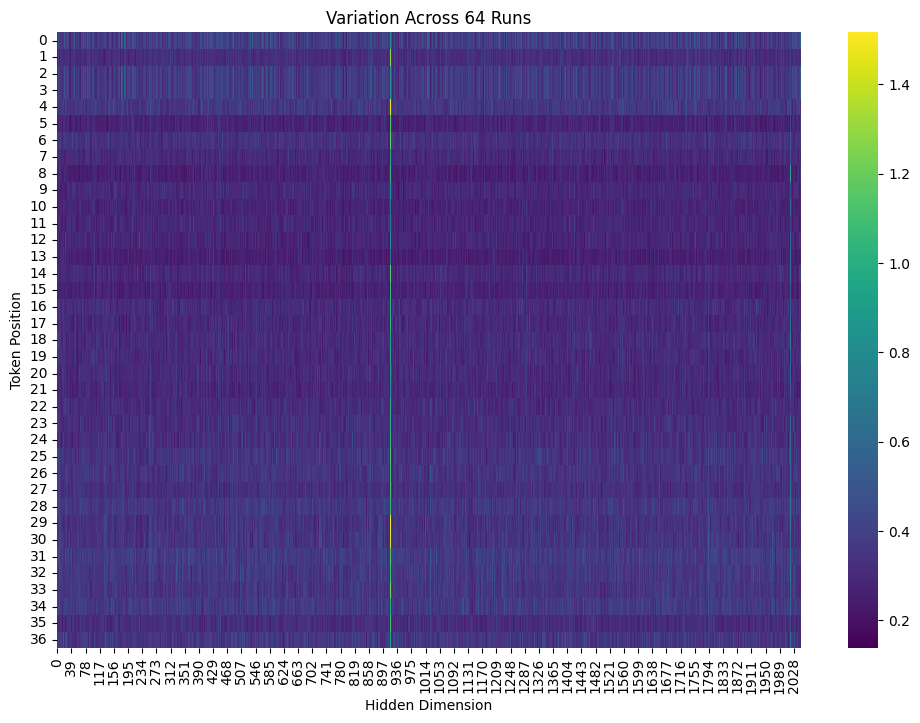

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
run_variation = data.std(dim=0)
plt.figure(figsize=(12, 8))
sns.heatmap(run_variation.numpy(), cmap='viridis')
plt.title("Variation Across 64 Runs")
plt.xlabel("Hidden Dimension")
plt.ylabel("Token Position")
plt.show()

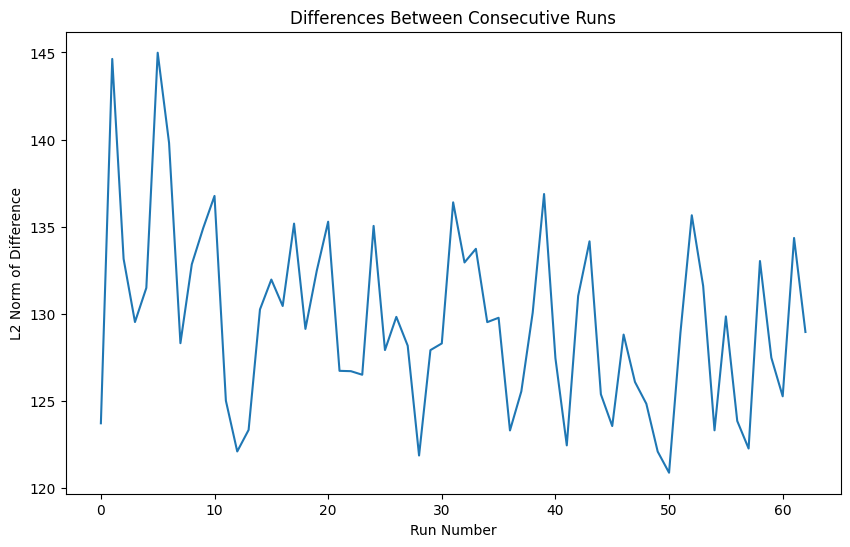

In [23]:
run_differences = torch.norm(data[1:] - data[:-1], dim=(1, 2))
plt.figure(figsize=(10, 6))
plt.plot(run_differences.numpy())
plt.title("Differences Between Consecutive Runs")
plt.xlabel("Run Number")
plt.ylabel("L2 Norm of Difference")
plt.show()

In [37]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the vector
vector = torch.load('refusal_dir_layer_16.pt', map_location=torch.device('cpu'))

# Ensure vector is 2D for broadcasting
if vector.dim() == 1:
    vector = vector.unsqueeze(0)

<ipython-input-37-947c3d31c9b7>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vector = torch.load('refusal_dir_layer_16.pt', map_location=torch.device('cpu'))


In [30]:
# Function to calculate cosine similarity
def cosine_similarity(a, b):
    return torch.nn.functional.cosine_similarity(a, b, dim=-1)
# Calculate cosine similarity for each token in the first 4 runs
similarities = []
for run in range(64):
    run_data = data[run]  # Shape: [37, 2048]
    sim = cosine_similarity(run_data, vector)
    similarities.append(sim)

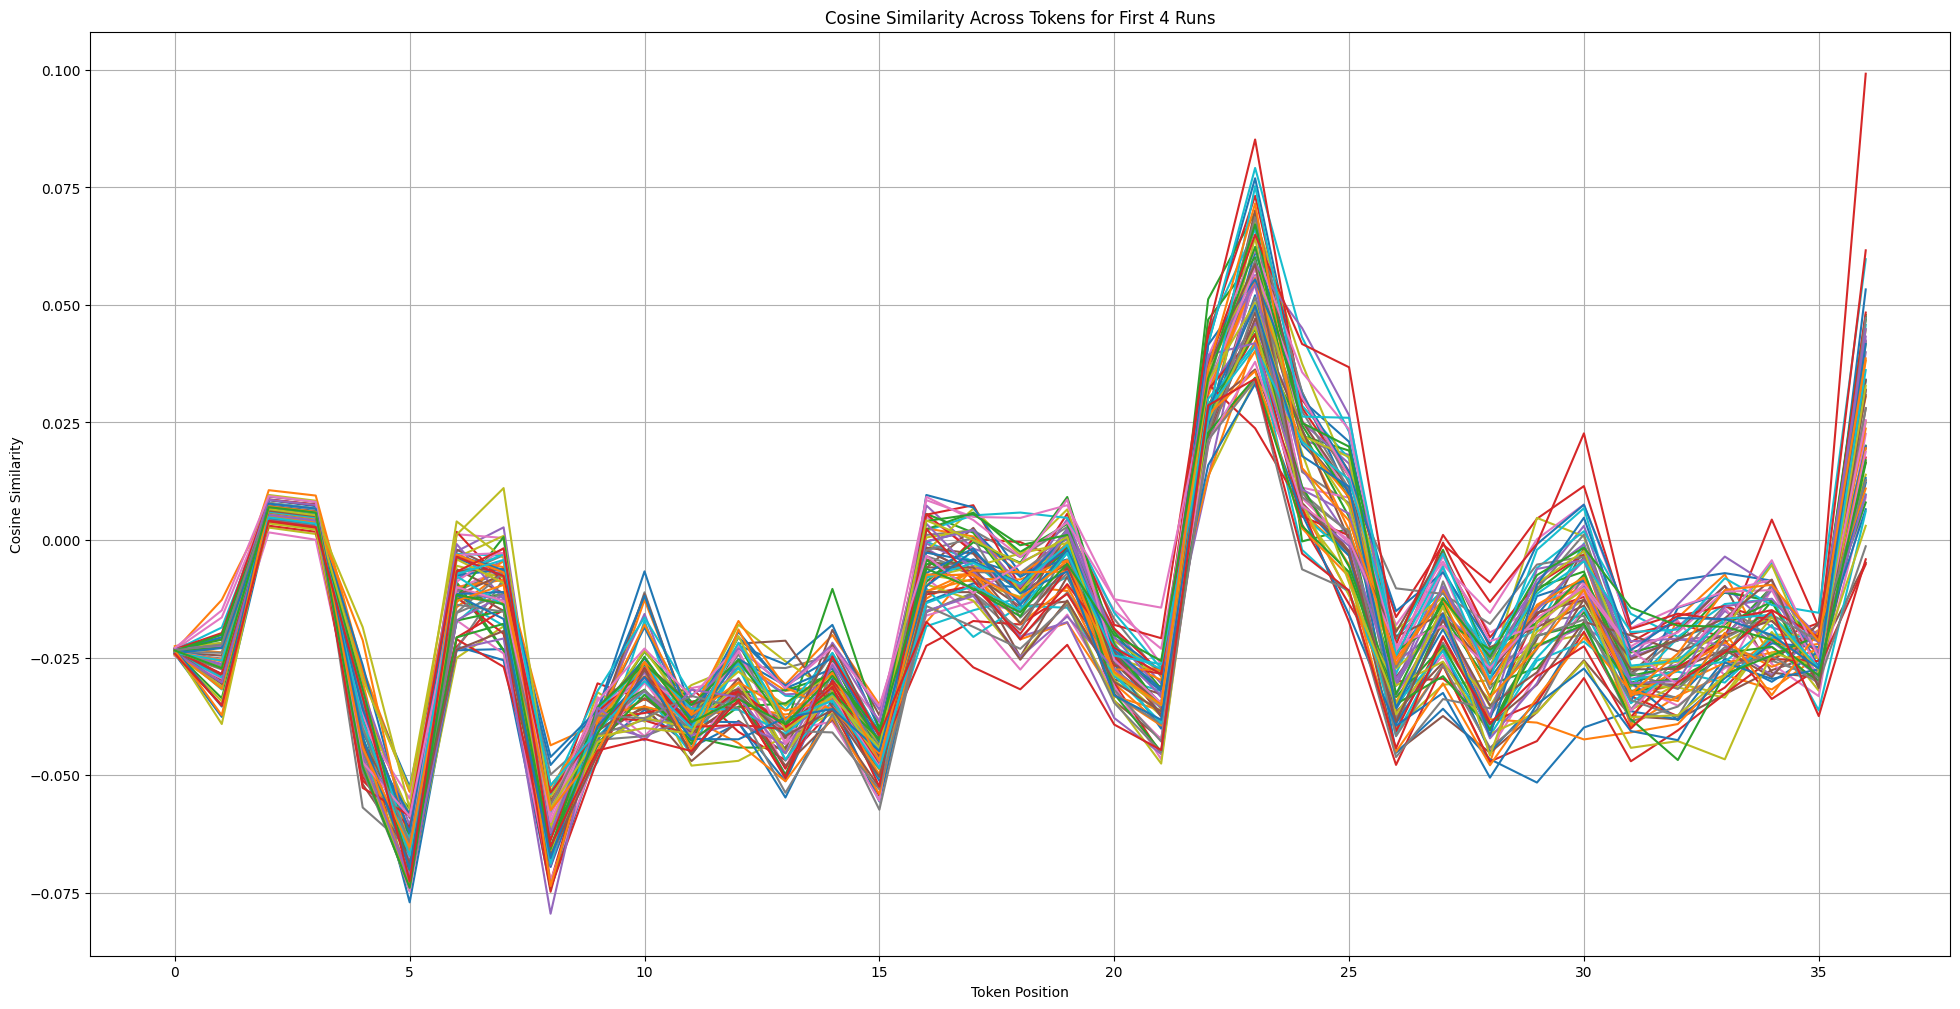

In [38]:
plt.figure(figsize=(24, 12))
for i in range(64):
    plt.plot(similarities[i], label=f'Run {i+1}')
plt.title("Cosine Similarity Across Tokens for First 4 Runs")
plt.xlabel("Token Position")
plt.ylabel("Cosine Similarity")
plt.grid(True)
plt.show()